In [270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import warnings 
warnings.filterwarnings('ignore')

### load the dataset

In [271]:
df=pd.read_csv("IMDb Movies India.csv", encoding='ISO-8859-1')
df.head(10)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
5,...Aur Pyaar Ho Gaya,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
7,.in for Motion,(2008),59 min,Documentary,NaN,NaN,Anirban Datta,NaN,NaN,NaN
8,?: A Question Mark,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
9,@Andheri,(2014),116 min,"Action, Crime, Thriller",4.0,11,Biju Bhaskar Nair,Augustine,Fathima Babu,Byon


In [272]:
df.describe().round(2)

,Rating
count,7919.00
mean,5.84
std,1.38
min,1.10
25%,4.90
50%,6.00
75%,6.80
max,10.00


In [273]:
df.columns

Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3'],
      dtype='object')

In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


# Feature Engineering

### Handling duplicate values

In [275]:
df[df.duplicated()]

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1250,Arab Ka Sona - Abu Kaalia,(1979),NaN,Action,NaN,NaN,Master Bhagwan,Meena Rai,Dara Singh,NaN
1769,Balidan,(1992),NaN,Drama,NaN,NaN,NaN,NaN,NaN,NaN
4723,First Time - Pehli Baar,(2009),NaN,NaN,NaN,NaN,Raja Bundela,Zeenat Aman,Nitin Arora,Raj Babbar
9713,Musafir,NaN,NaN,Thriller,NaN,NaN,Shiva Dagar,NaN,NaN,NaN
13069,Shivani,(2019),NaN,Crime,NaN,NaN,Ugresh Prasad Ujala,Santosh,NaN,NaN
13308,Slumdog Karodpati,(2019),118 min,Thriller,NaN,NaN,Rajesh Patole,Udhav Garje,Rahul Gavane,Govindrao


In [276]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### Handling Missing Values

In [277]:
df['Year'] = df['Year'].fillna('None')
df['Duration'] = df['Duration'].fillna('0 min').str.replace(' min', '').astype(int)
df['Genre'] = df['Genre'].fillna('None')
df['Director'] = df['Director'].fillna('None')

In [278]:
df['Genre'].fillna(df['Genre'].mode()[0], inplace=True)
df['Director'].fillna(df['Director'].mode()[0], inplace=True)


In [279]:
df.isnull().sum()

Name           0
Year           0
Duration       0
Genre          0
Rating      7584
Votes       7583
Director       0
Actor 1     1615
Actor 2     2381
Actor 3     3140
dtype: int64

### Extracting new features

In [280]:
genres = df['Genre'].dropna().str.split(',').explode()
genres = genres.str.strip()

In [281]:
count = genres.value_counts()

In [282]:
count = count.sort_index().to_dict()
for genre, c in count.items():
    print(f"{genre}: {c}")

Action: 3542
Adventure: 541
Animation: 125
Biography: 208
Comedy: 2029
Crime: 1321
Documentary: 383
Drama: 7242
Family: 943
Fantasy: 458
History: 207
Horror: 524
Music: 90
Musical: 589
Mystery: 513
News: 9
None: 1876
Reality-TV: 3
Romance: 2449
Sci-Fi: 58
Short: 1
Sport: 70
Thriller: 1711
War: 47
Western: 5


In [283]:

g_avg = df.groupby('Genre')['Rating'].transform('mean')
df['Genre_avg_rating'] = g_avg

d_avg = df.groupby('Director')['Rating'].transform('mean')
df['Director_avg_rating'] = d_avg

In [284]:
a_avg = df.groupby('Actor 1')['Rating'].transform('mean')
df['Actor1_avg_rating'] = a_avg

a2_avg = df.groupby('Actor 2')['Rating'].transform('mean')
df['Actor2_avg_rating'] = a2_avg

a3_avg = df.groupby('Actor 3')['Rating'].transform('mean')
df['Actor3_avg_rating'] = a3_avg

In [285]:
df.dropna(inplace = True)

### converting datatypes of columns

In [286]:
df['Year'] = df['Year'].str.replace(r'[^\d]', '', regex=True) 
df['Year'] = pd.to_numeric(df['Year'], errors='coerce') 


In [287]:
df['Duration'] = df['Duration'].astype(str).str.extract('(\d+)')
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

In [288]:
df['Votes'] = df['Votes'].str.replace(',', '').astype(float)

# Data Visualization

In [289]:
plt.figure(figsize=(18,6))

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

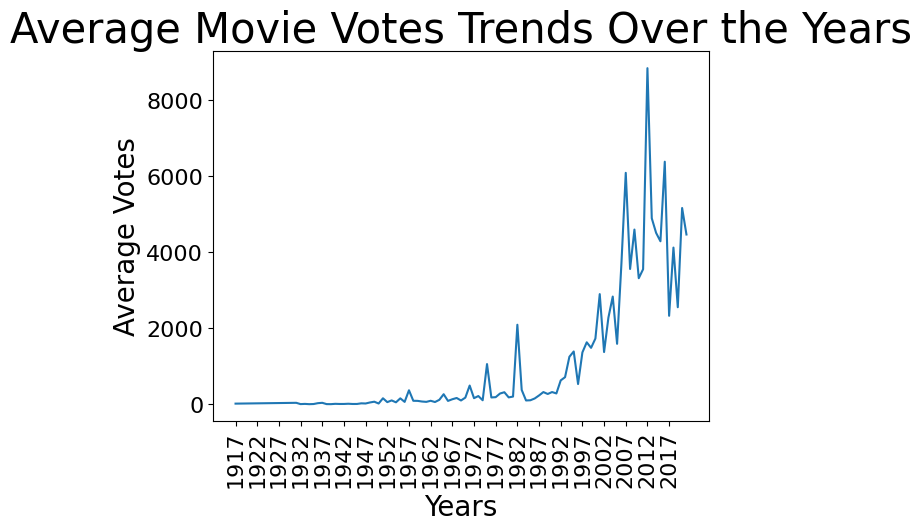

In [290]:

ax = sns.lineplot(data=df.groupby('Year')['Votes'].mean().reset_index(), x='Year', y='Votes')
tick_positions = range(min(df['Year']), max(df['Year']) + 1, 5)
y = [s*s for s in tick_positions]

ax.set_title("Average Movie Votes Trends Over the Years", fontsize=30)
ax.set_xticks(tick_positions)
plt.yticks(fontsize=16)
ax.set_xticklabels(tick_positions, rotation = 90, fontsize=16)
ax.set_xlabel("Years", fontsize=20)
ax.set_ylabel("Average Votes", fontsize=20)
plt.show()

In [291]:
filtered_genres = df['Genre'].dropna().str.split(',').explode()
filtered_genres = filtered_genres.str.strip()
genre_counts = filtered_genres.value_counts()
GenreCounts = genre_counts.sort_index().to_dict()


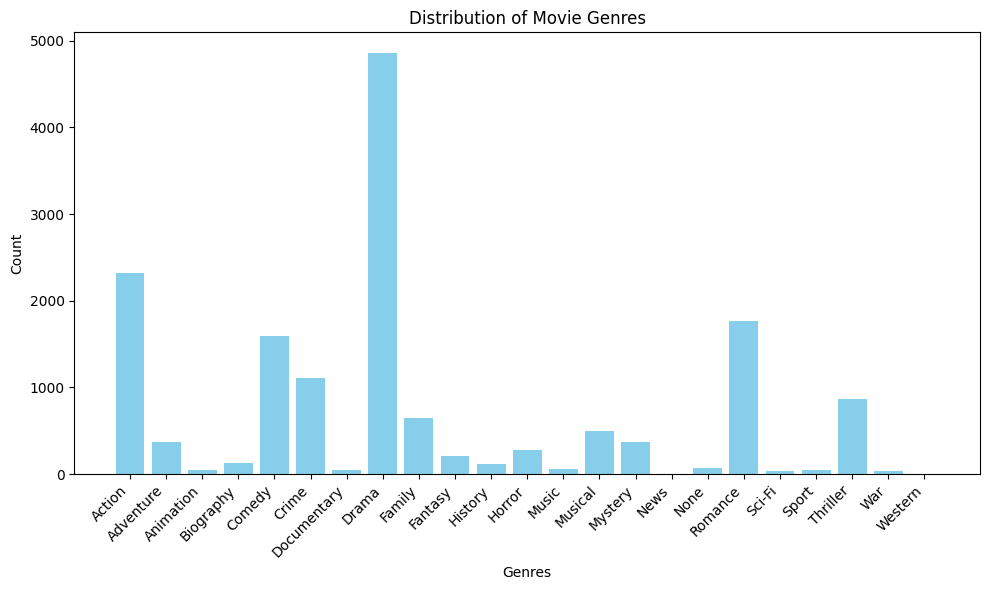

In [292]:
plt.figure(figsize=(10, 6)) 
plt.bar(GenreCounts.keys(), GenreCounts.values(), color='skyblue')

plt.title('Distribution of Movie Genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout() 
plt.show()


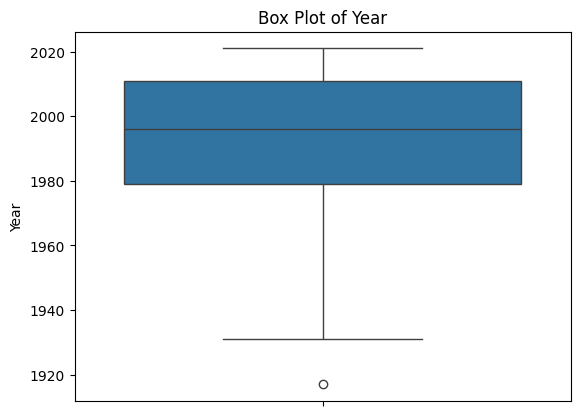

In [293]:
ax = sns.boxplot(data=df, y='Year')
ax.set_ylabel('Year')
ax.set_title('Box Plot of Year')
plt.show()


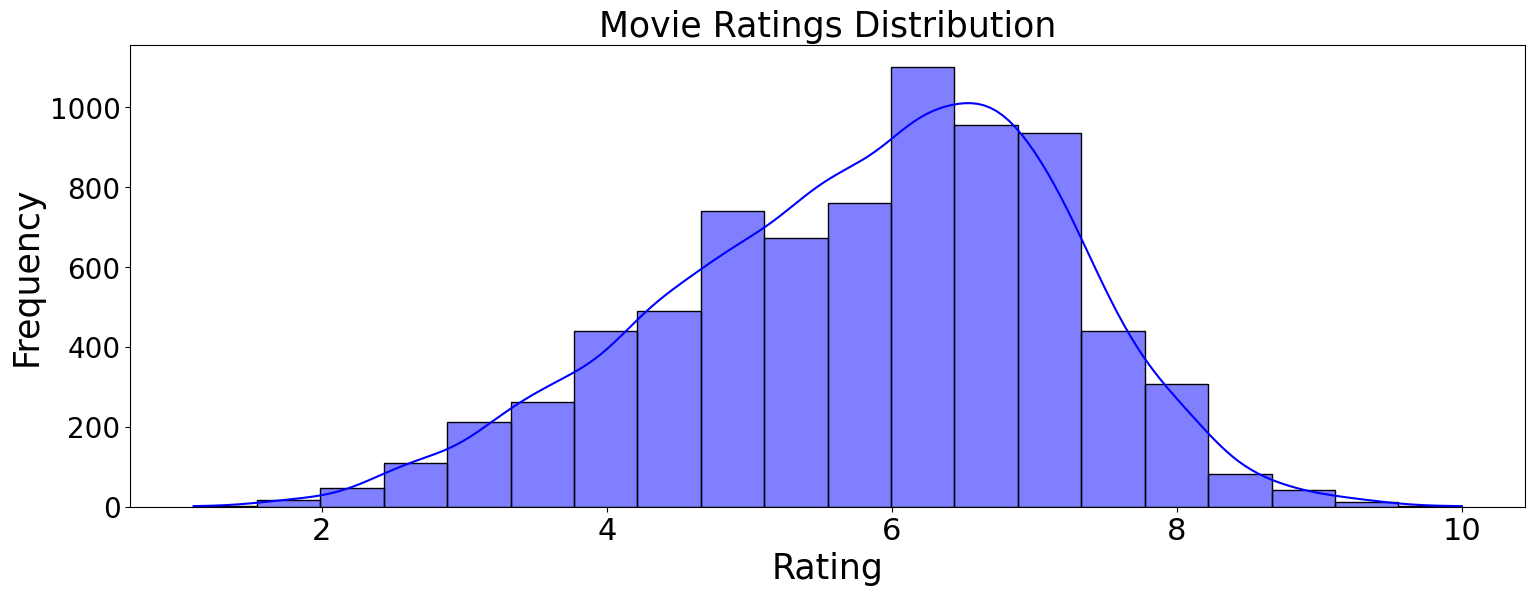

In [294]:
plt.figure(figsize=(18, 6))
ax = sns.histplot(data = df, x = "Rating", bins = 20, kde = True, color='blue')
ax.set_xlabel('Rating',size=25)
ax.set_ylabel('Frequency',size=25)
plt.xticks(fontsize=22) 
plt.yticks(fontsize=20) 
ax.set_title('Movie Ratings Distribution',size=25)
plt.show()

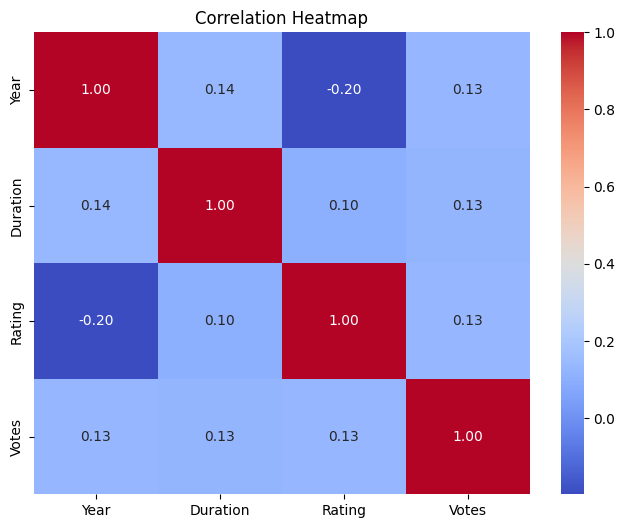

In [295]:
data = df[['Year', 'Duration', 'Rating', 'Votes']]
corr = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


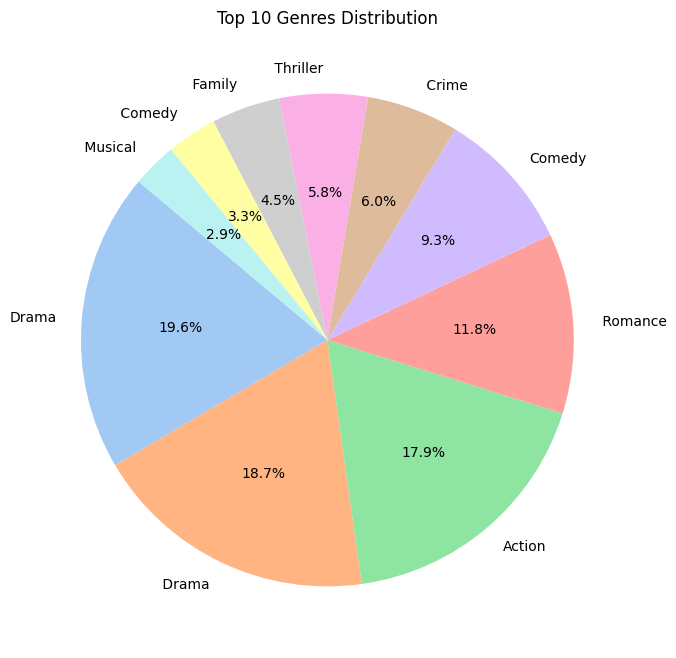

In [296]:
genre_counts = df['Genre'].str.split(',').explode().value_counts()
plt.figure(figsize=(8, 8))
genre_counts[:10].plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Top 10 Genres Distribution')
plt.ylabel('')
plt.show()


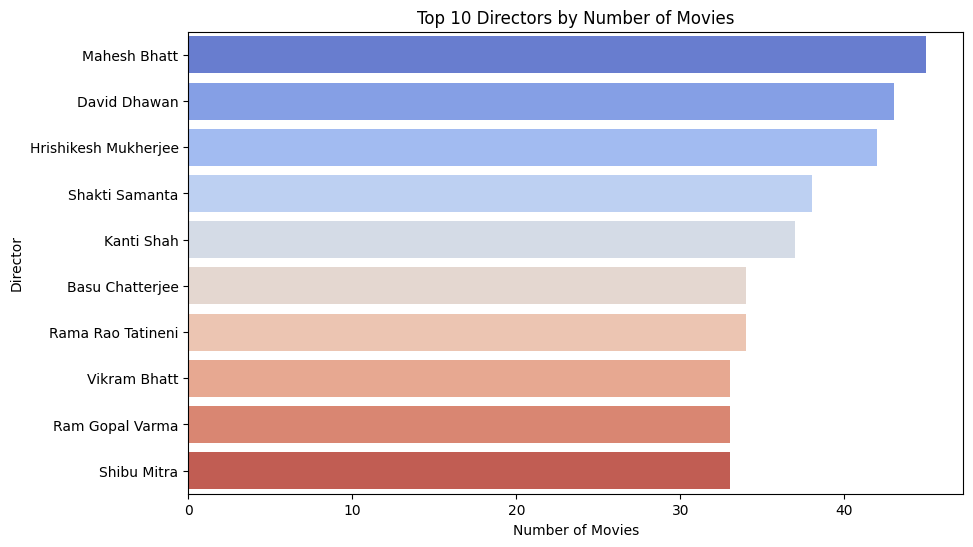

In [297]:
plt.figure(figsize=(10, 6))
top_directors = df['Director'].value_counts().head(10)
sns.barplot(x=top_directors.values, y=top_directors.index, palette='coolwarm')
plt.title('Top 10 Directors by Number of Movies')
plt.xlabel('Number of Movies')
plt.ylabel('Director')
plt.show()


### Splitting the dataset

In [298]:
x = df[[ 'Year', 'Votes', 'Duration', 'Genre_avg_rating','Director_avg_rating','Actor1_avg_rating', 'Actor2_avg_rating',
        'Actor3_avg_rating']]
y = df['Rating']

In [299]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=72)

# Training the Model

In [300]:
DecisionTree = DecisionTreeRegressor(random_state=42)
DecisionTree.fit(x_train, y_train)
y_pred1 = DecisionTree.predict(x_test)

In [301]:
print("Accuracy: {:0.2f}%".format(r2_score(y_test, y_pred1)*100))
    

Accuracy: 62.21%


In [302]:
print("Mean Squared Error: {:0.2f}".format(mean_squared_error(y_test, y_pred1)))

Mean Squared Error: 0.71


In [303]:
print("Mean absolute error: {:0.2f}".format(mean_absolute_error(y_test, y_pred1)))

Mean absolute error: 0.57


In [304]:
XGBR = XGBRegressor(n_estimators=100, random_state=42)
XGBR.fit(x_train, y_train)
y_pred2 = XGBR.predict(x_test)

In [307]:
print("Accuracy: {:0.2f}%".format(r2_score(y_test, y_pred2)*100))

Accuracy: 81.55%


In [309]:
print("Mean Squared Error: {:0.2f}".format(mean_squared_error(y_test, y_pred2)))
print("Mean absolute error: {:0.2f}".format(mean_absolute_error(y_test, y_pred1)))

Mean Squared Error: 0.35
Mean absolute error: 0.57


In [313]:
rmse = mean_squared_error(y_test, y_pred2, squared=False)
print(f"Root Mean Squared Error: {rmse:.2f}")

Root Mean Squared Error: 0.59


In [314]:
r2 = r2_score(y_test, y_pred2)
print(f"R-squared: {r2:.2f}")

R-squared: 0.82
